## makemore part3


In [34]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
# !pip install matplotlib



In [36]:
words=open("names.txt",'r').read().splitlines()

In [38]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [40]:
chars=sorted(list(set(''.join(words))))

In [42]:

stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}


In [44]:
#build dataset
block_size=3
def build_dataset(words):
    X=[]
    Y=[]
    for word in words:
        context=[0]*block_size
       
        for ch in word+'.':
            ix=stoi[ch]
            X.append(context)
            Y.append(ix)
            context=context[1:]+[ix]
    X=torch.tensor(X)  
    Y=torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y
import random
random.seed(32)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr,Ytr=build_dataset(words[:n1])
Xdev,Ydev=build_dataset(words[n1:n2])
Xte,Yte=build_dataset(words[n2:])

        

torch.Size([182408, 3]) torch.Size([182408])
torch.Size([22794, 3]) torch.Size([22794])
torch.Size([22944, 3]) torch.Size([22944])


In [135]:
#mlp revisted
n_emb=10
n_hidden=200
g=torch.Generator().manual_seed(2147483647)
C=torch.randn((27,n_emb),generator=g)
w1=torch.randn((block_size*n_emb,n_hidden))*0.1
b1=torch.randn(n_hidden,generator=g)*0.01

w2=torch.randn((n_hidden,27),generator=g)*0.01 #to create uniform distribution initially
b2=torch.randn(27,generator=g)*0

parameters=[C,w1,b1,w2,b2]
for p in parameters:
    p.requires_grad=True


In [151]:
#model training
max_steps=200000
batch_size=32
lossi=[]
for i in range(max_steps):
    ix=torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb=Xtr[ix]
    Yb=Ytr[ix]

    #forward pass
    emb=C[Xb]
    
    embcat=emb.view(emb.shape[0],-1)
    hreact=embcat@w1+b1
    h=torch.tanh(hreact)
    logits=h@w2+b2
    loss=F.cross_entropy(logits,Yb)
    
    #backward pass
    for param in parameters:
        param.grad=None
    loss.backward()
    lr=0.1 if i<100000 else 0.01
    for p in parameters:
        p.data+=-lr*p.grad
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss)
    
        

      0/ 200000: 2.1838
  10000/ 200000: 1.9679
  20000/ 200000: 2.4576
  30000/ 200000: 2.4378
  40000/ 200000: 2.0473
  50000/ 200000: 2.2142
  60000/ 200000: 2.2586
  70000/ 200000: 1.9600
  80000/ 200000: 2.1061
  90000/ 200000: 2.0341
 100000/ 200000: 1.6900
 110000/ 200000: 2.1113
 120000/ 200000: 2.0203
 130000/ 200000: 2.5328
 140000/ 200000: 2.1611
 150000/ 200000: 1.9414
 160000/ 200000: 1.9136
 170000/ 200000: 2.2620
 180000/ 200000: 1.9491
 190000/ 200000: 2.2236


In [117]:
h

tensor([[-1.0000, -1.0000, -0.9903,  ..., -0.9999,  0.2809,  0.9993],
        [-1.0000,  1.0000,  0.9921,  ...,  0.4231, -0.9999,  0.9996],
        [-0.9102, -0.7729,  0.8700,  ...,  0.8865,  0.3857, -0.9987],
        ...,
        [-1.0000,  1.0000, -0.9996,  ..., -1.0000,  0.9738, -1.0000],
        [-1.0000, -0.9960, -0.9992,  ..., -1.0000, -1.0000, -1.0000],
        [-0.2689, -0.9736, -1.0000,  ..., -0.9973, -0.9848, -0.9986]],
       grad_fn=<TanhBackward0>)

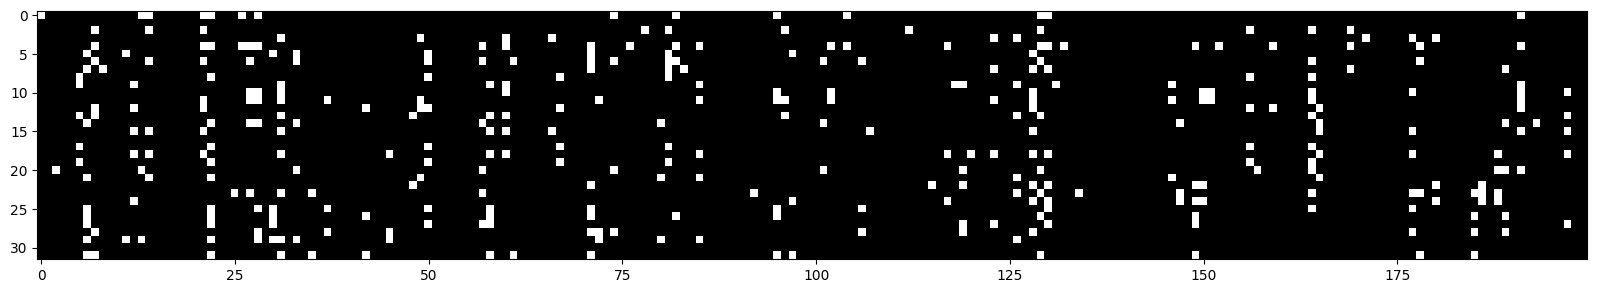

In [141]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

(array([326., 153., 124., 100.,  73.,  83.,  85.,  81.,  75., 107.,  83.,
         69.,  90.,  79.,  80., 112., 104., 141., 116., 122., 141., 169.,
        187., 208., 247., 236., 189., 172., 173., 125., 132., 104., 137.,
        127., 114., 114.,  91.,  86.,  84.,  78.,  86.,  78.,  83.,  93.,
         77.,  78.,  91., 130., 145., 422.]),
 array([-9.99996662e-01, -9.59996763e-01, -9.19996865e-01, -8.79996966e-01,
        -8.39997067e-01, -7.99997169e-01, -7.59997270e-01, -7.19997371e-01,
        -6.79997473e-01, -6.39997574e-01, -5.99997675e-01, -5.59997777e-01,
        -5.19997878e-01, -4.79997979e-01, -4.39998081e-01, -3.99998182e-01,
        -3.59998283e-01, -3.19998385e-01, -2.79998486e-01, -2.39998587e-01,
        -1.99998689e-01, -1.59998790e-01, -1.19998891e-01, -7.99989927e-02,
        -3.99990940e-02,  8.04662704e-07,  4.00007033e-02,  8.00006020e-02,
         1.20000501e-01,  1.60000399e-01,  2.00000298e-01,  2.40000197e-01,
         2.80000095e-01,  3.19999994e-01,  3.59999

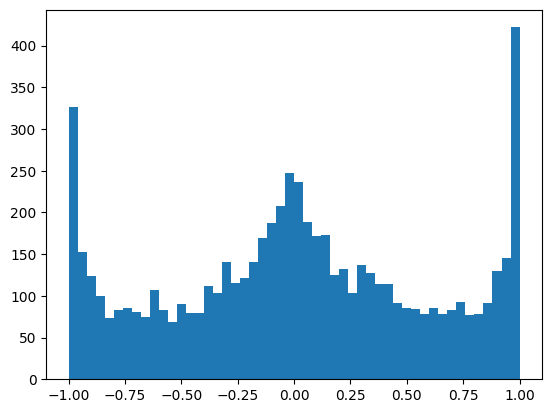

In [145]:
plt.hist(h.view(-1).tolist(),50)

(array([1.000e+00, 3.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 3.000e+00,
        5.000e+00, 5.000e+00, 6.000e+00, 1.300e+01, 9.000e+00, 1.100e+01,
        3.100e+01, 3.100e+01, 3.600e+01, 6.300e+01, 7.900e+01, 1.010e+02,
        1.370e+02, 1.720e+02, 2.110e+02, 3.400e+02, 4.490e+02, 8.600e+02,
        1.365e+03, 7.530e+02, 4.500e+02, 2.970e+02, 1.890e+02, 1.690e+02,
        1.320e+02, 9.700e+01, 7.400e+01, 7.800e+01, 6.300e+01, 3.900e+01,
        3.200e+01, 1.800e+01, 1.200e+01, 1.700e+01, 1.900e+01, 6.000e+00,
        4.000e+00, 1.000e+00, 0.000e+00, 4.000e+00, 1.000e+00, 4.000e+00,
        0.000e+00, 2.000e+00]),
 array([-6.64892387, -6.37635281, -6.10378174, -5.83121067, -5.5586396 ,
        -5.28606853, -5.01349747, -4.7409264 , -4.46835533, -4.19578426,
        -3.9232132 , -3.65064213, -3.37807106, -3.10549999, -2.83292892,
        -2.56035786, -2.28778679, -2.01521572, -1.74264465, -1.47007359,
        -1.19750252, -0.92493145, -0.65236038, -0.37978931, -0.10721825,
         0.

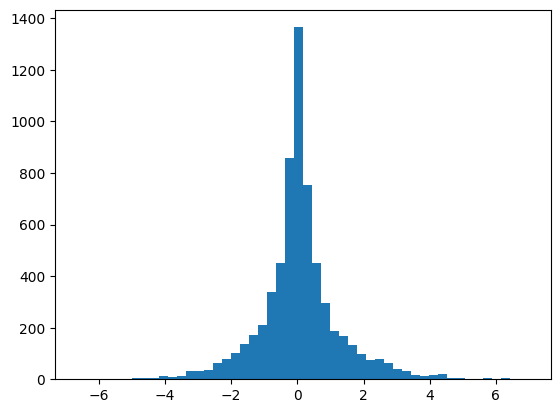

In [147]:
plt.hist(hreact.view(-1).tolist(),50)

In [90]:
@torch.no_grad() #this decorator disable gradient tracking
def split_loss(split):
    x,y={'train':(Xtr,Ytr),
        'dev':(Xdev,Ydev),
        'test':(Xte,Yte)}[split]
    emb=C[x]
    embcat=e.view(emb.shape[0],-1)
    hreact=embcat@w1+b1
    h=torch.tanh(hreact)

    logits=h@w2+b2
    loss=F.cross_entropy(logits,y)
    print(loss.item())
split_loss('train')
split_loss('dev')
    

2.1276886463165283
2.166318416595459


## points to note

In [100]:

#1.fix initial loss ,we expect uniform distribution of probabliites or near to zero
logits=torch.tensor([1.0,1.0,1.0,1.0])
probs=torch.softmax(logits,dim=0)
loss=-probs[2].log()
loss

tensor(0.0535)

In [102]:
-torch.tensor(1/27.0).log() #THIS WHAT expecting intial loss 

tensor(3.2958)

In [114]:
#multiply w2 with 0.01 and b2 with 0
#changing initail loss help us to maximize the no of iterations for optimizing neural net instead of wasting some iteration for sqashing down the initial loss

In [129]:
#2.fixing the saturated tanh
# many values of h takes 1 or -1 since tanh squashes values in between -1 to 1
#tanh backpropagation
#self.grad+=(1-t**2)*out.grad
#when t ==-1 or 1 self.grad not get updated,backward gradient get destroyed  as neuron is in flat tail


In [149]:
#200 neurons and 32 inputs if any one of the vertical line is completely white then it is dead neuron
# for any example if the neuron never activate ,ie it produces +1 or -1 then it dead neuron that means it never learn ,weights and bais are never changes
#sometimes for higher learning rate neuraon gets too much of a gradient and they knock out ,from then on no example can activate this neuron ,it remains as dead neuron
#activation functions with flat parts may suffer from this issue
#hreact to far from zero ,we need to make hreact near to zero
#mutiply w1 and b1 with 0.01

In [153]:
# deeper the network ,it will less forgiving to these errors

tensor(-0.0013) tensor(1.0083)
tensor(0.0015) tensor(1.0216)


(array([3.81427969e-05, 0.00000000e+00, 7.62855937e-05, 3.81428662e-05,
        3.81427969e-05, 1.14428391e-04, 1.52571465e-04, 5.72142994e-04,
        8.39141531e-04, 1.39221335e-03, 2.07878432e-03, 4.17663626e-03,
        7.57135206e-03, 1.34453481e-02, 2.32671272e-02, 3.83144743e-02,
        5.81296224e-02, 9.33165222e-02, 1.36341427e-01, 1.94433261e-01,
        2.56472166e-01, 3.27590007e-01, 3.89342599e-01, 4.15470415e-01,
        4.16481956e-01, 3.69985130e-01, 3.09586574e-01, 2.41825332e-01,
        1.75895828e-01, 1.20626595e-01, 8.33612342e-02, 5.17025611e-02,
        3.34130901e-02, 2.02728965e-02, 1.18624530e-02, 6.99920322e-03,
        3.89056528e-03, 2.51742459e-03, 1.25871688e-03, 4.57713562e-04,
        4.38642164e-04, 2.47928180e-04, 1.33499789e-04, 3.81429356e-05,
        5.72141953e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.90713984e-05]),
 array([-6.25580883, -5.99363613, -5.73146391, -5.46929121, -5.20711899,
        -4.94494629, 

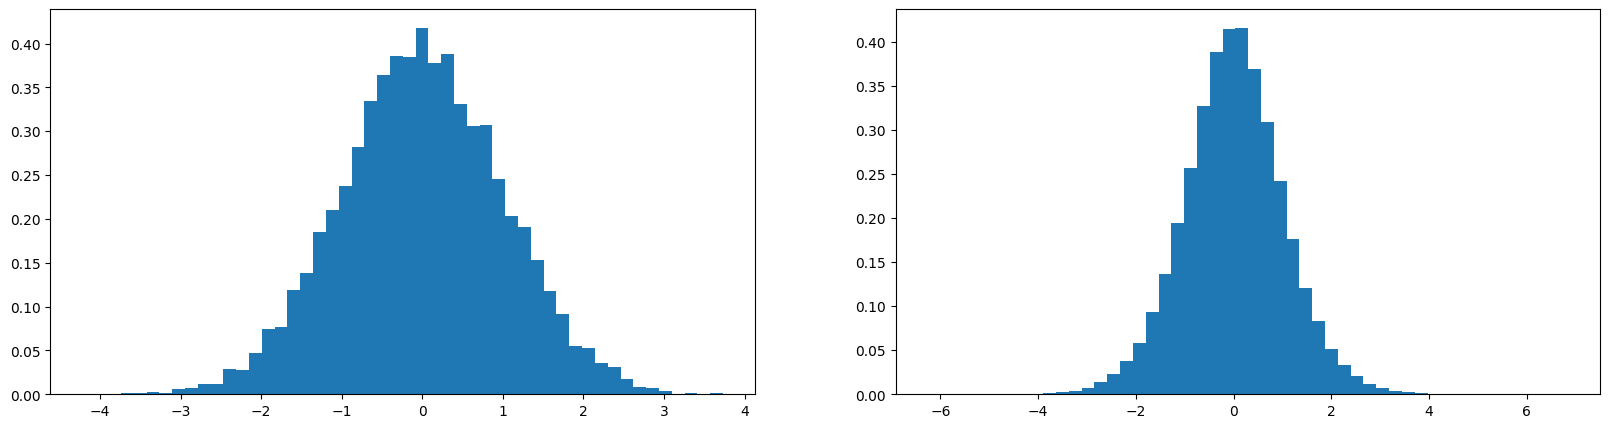

In [167]:
#identifying  multiplication terms 
#preserve guassian std 
x=torch.randn(1000,10)
w=torch.randn(10,200)/(10**0.5)
y=x@w

print(x.mean(),x.std())
print(y.mean(),y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1),50,density=True)
plt.subplot(122)
plt.hist(y.view(-1),50,density=True)